# Distribution B - Fit from Samples

In [207]:
import DistBTrunc as dbt
import DistExampB as db

from math import ceil, floor
from matplotlib import pyplot as plot
from sympy import Symbol

from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import FitLstSqr, Interp

In [208]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

In [209]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 749


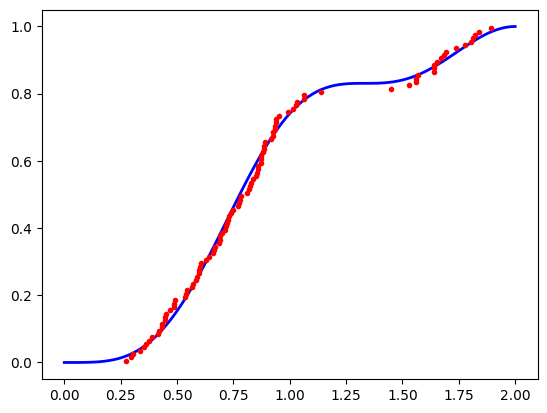

In [210]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Map to Z

In [211]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [212]:
map_.forSym

log(x/(2 - x))

In [213]:
sampZ = tuple(map_.Forward(x) for x in samp)

In [214]:
zRange = MinMax(sampZ)
zRange

(-1.8322009125466414, 2.8750132461604587)

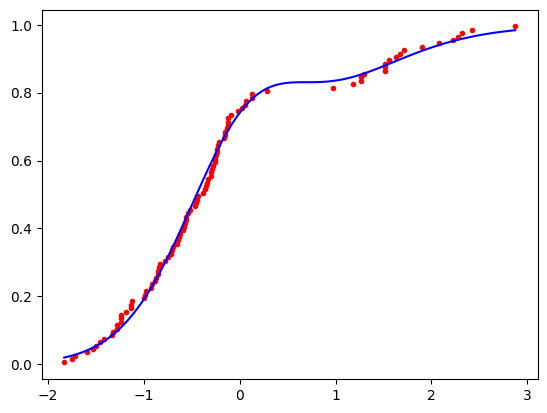

In [215]:
plot.plot(sampZ,quant, '.', c='red')

zGrid = Grid1(*zRange, nPlot)
nullGrid = [dist.Cdf(map_.Inverse(z)) for z in zGrid]
plot.plot(zGrid,nullGrid, c='blue')

## Residue

In [216]:
sampRes = tuple(q - dbt.NullZ(z) for (z,q) in zip(sampZ, quant))

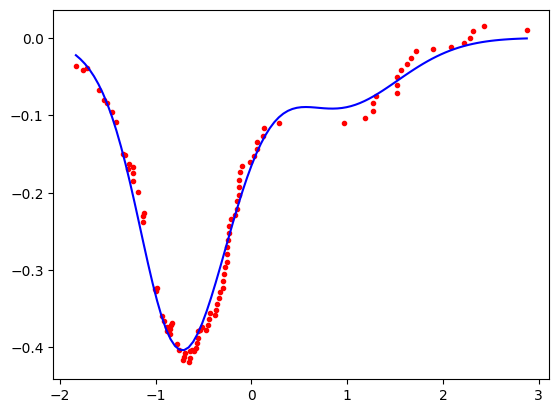

In [217]:
plot.plot(sampZ,sampRes, '.', c='red')

resGrid = tuple(dbt.ResZ(z) for z in zGrid)
plot.plot(zGrid,resGrid, c='blue')

### Sinc Fit

In [218]:
zLim = MinMax(sampZ)
zMin,zMax = zLim
zMin,zMax

(-1.8322009125466414, 2.8750132461604587)

In [219]:
zRange = zMax - zMin
zRange

4.7072141587071

In [220]:
hMin,hMax = 0.2,3

In [221]:
nMin = ceil(zRange / hMax) + 1
nMin

3

In [222]:
nMax = floor(zRange / hMin) + 1
nMax

24

In [223]:
nL = tuple(range(nMin, nMax + 1))

In [224]:
import Sinc
import importlib
importlib.reload(Sinc)

<module 'Sinc' from 'F:\\Users\\Kenne.DESKTOP-BT6VROU\\Documents\\GitHub\\ManetSim\\CdfFit\\Sinc.py'>

In [225]:
sampPoint = tuple(zip(sampZ, sampRes))

In [226]:
fitTab = tuple((n, *Sinc.FitLstSqr(sampPoint, zLim,n)) for n in nL)
fitTab[0]

(3,
 ((-1.8322009125466414, -0.177880204746658),
  (0.5214061668069088, -0.23237437474162043),
  (2.875013246160459, 0.11715377134455088)),
 0.7735469018062103,
 3.152969980382798)

Text(0, 0.5, 'Residue')

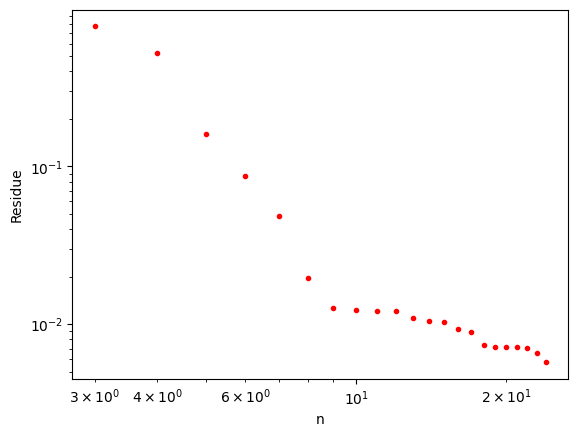

In [227]:
res = tuple(r for (_,_,r,_) in fitTab)
plot.loglog(nL, res, '.', c='red')

plot.xlabel('n')
plot.ylabel('Residue')

Text(0, 0.5, 'Condition Number')

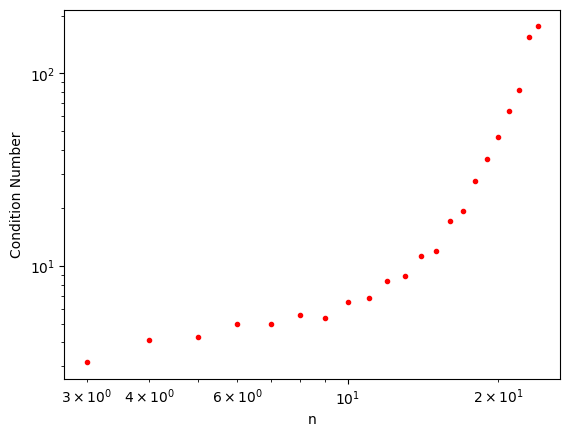

In [228]:
cond = tuple(c for (_,_,_,c) in fitTab)
plot.loglog(nL, cond, '.', c='red')

plot.xlabel('n')
plot.ylabel('Condition Number')

#### Individual fits

In [229]:
fitRes = Sinc.FitLstSqr(sampPoint, zLim,3)
sincPoint = fitRes[0]

In [230]:
fitTab[0]

(3,
 ((-1.8322009125466414, -0.177880204746658),
  (0.5214061668069088, -0.23237437474162043),
  (2.875013246160459, 0.11715377134455088)),
 0.7735469018062103,
 3.152969980382798)

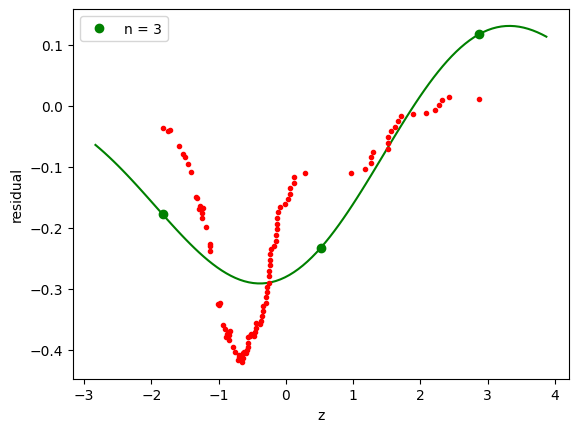

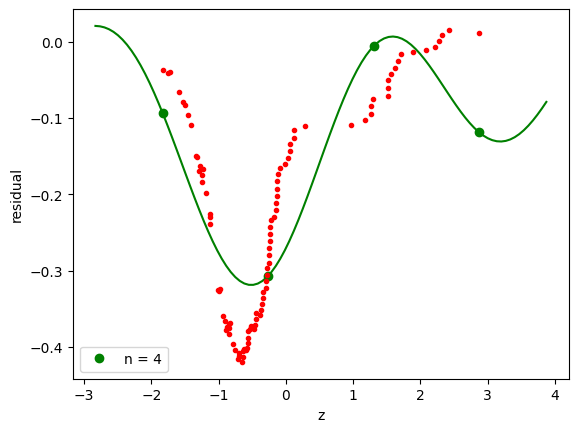

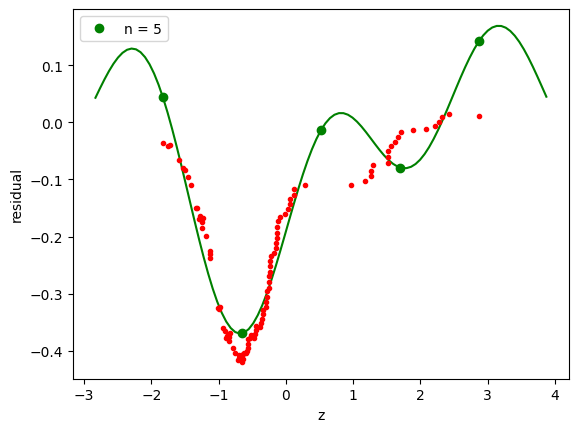

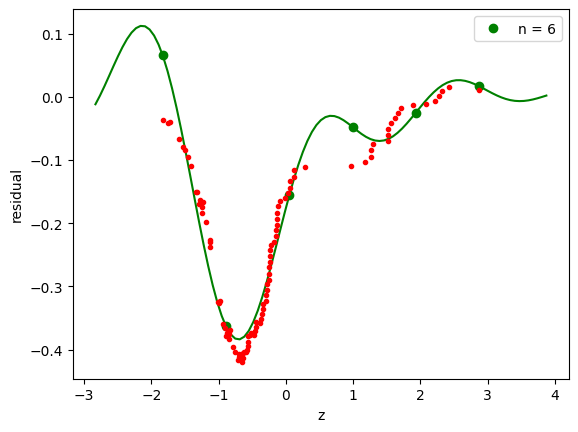

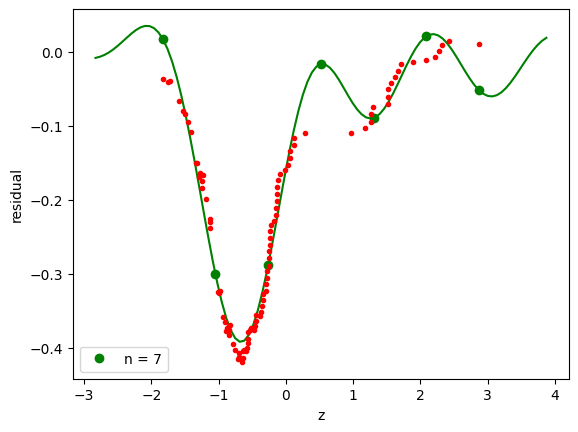

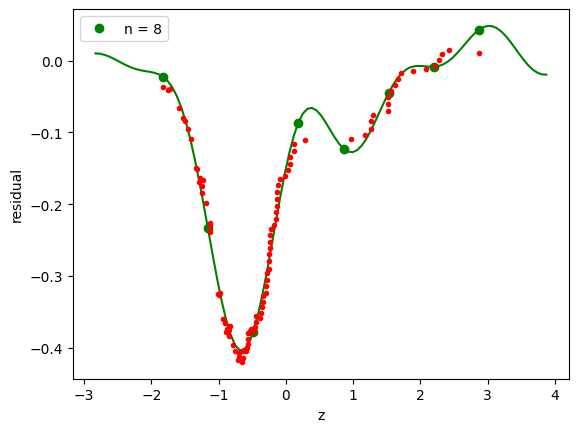

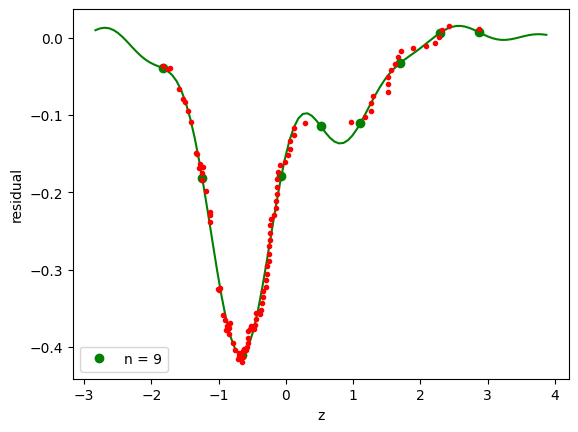

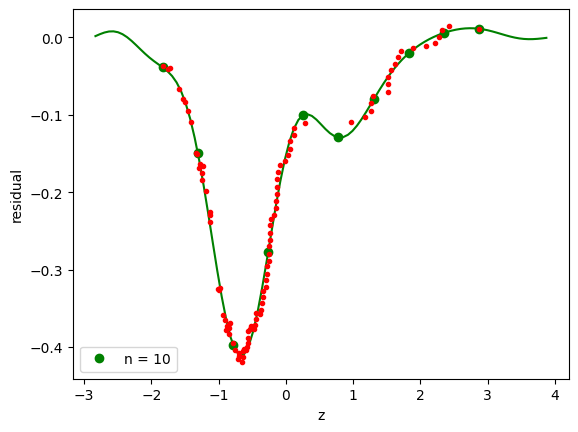

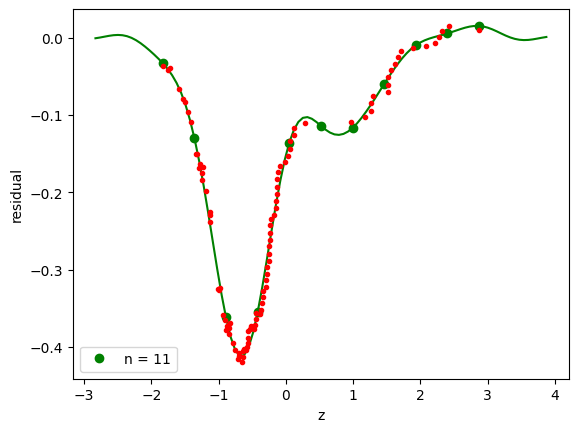

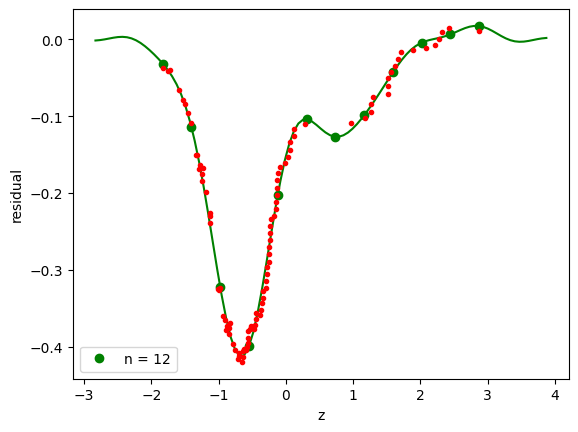

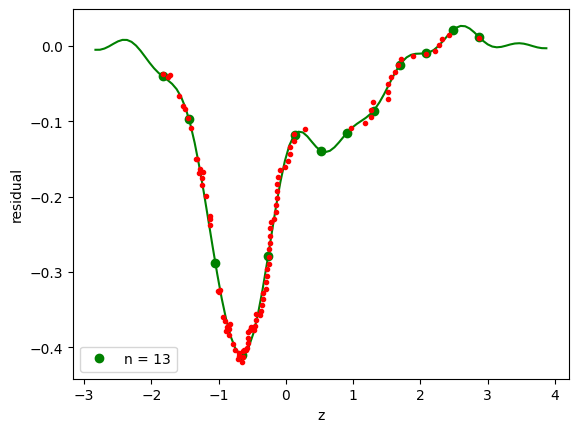

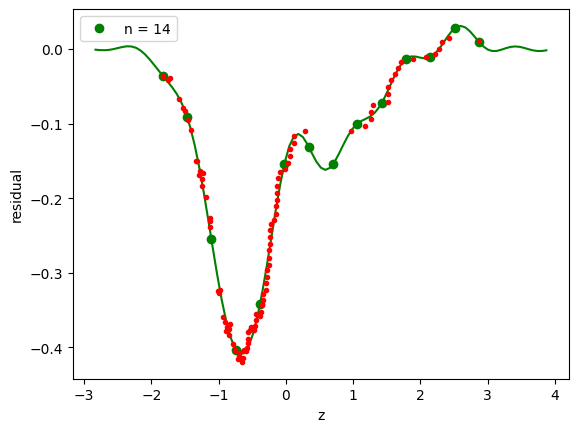

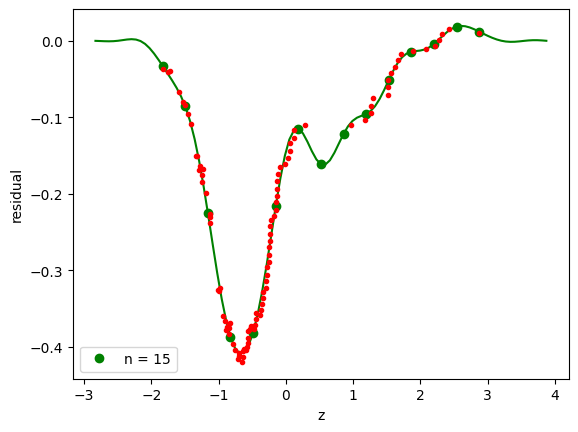

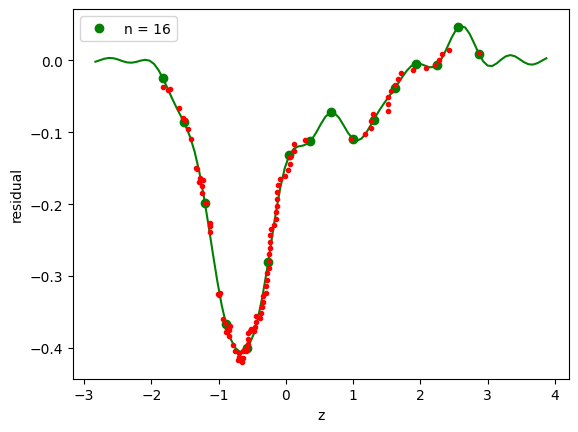

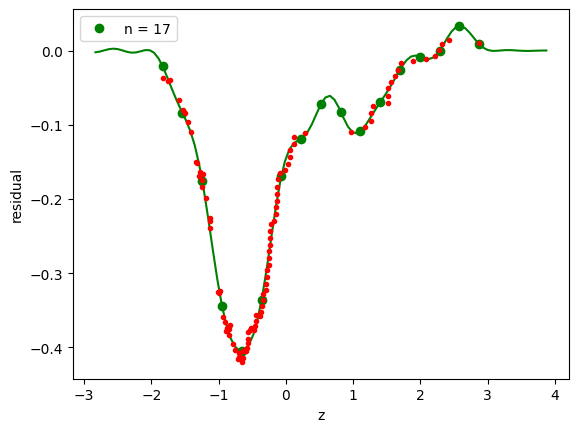

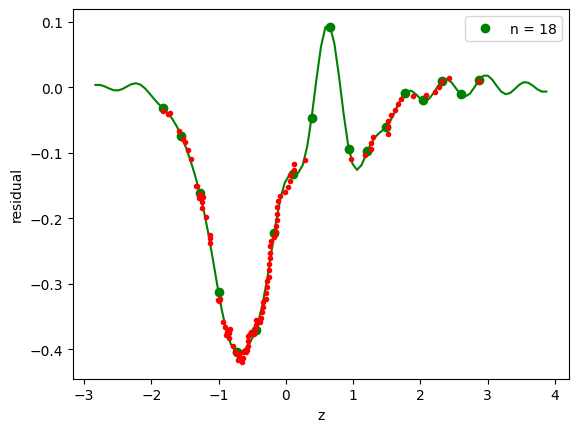

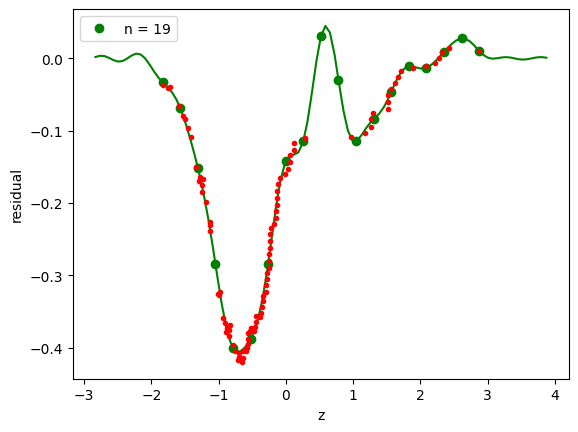

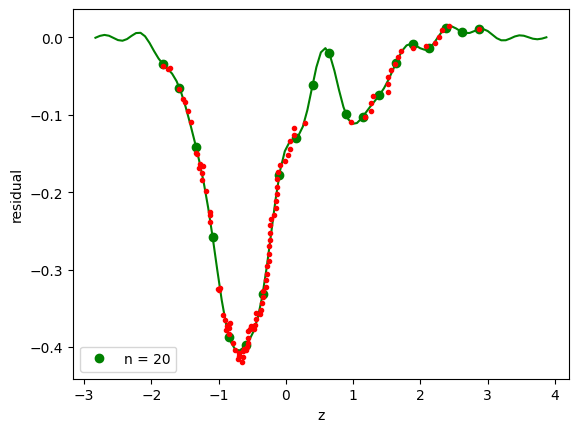

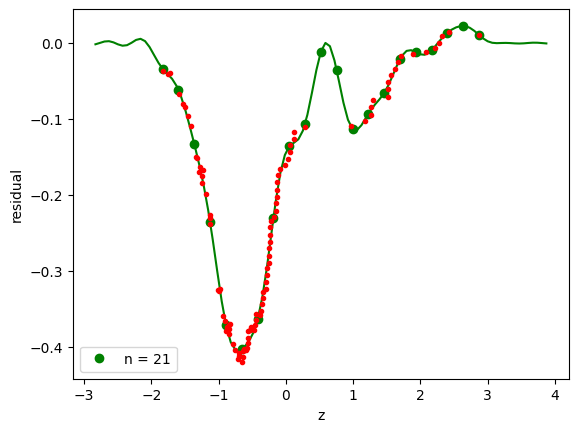

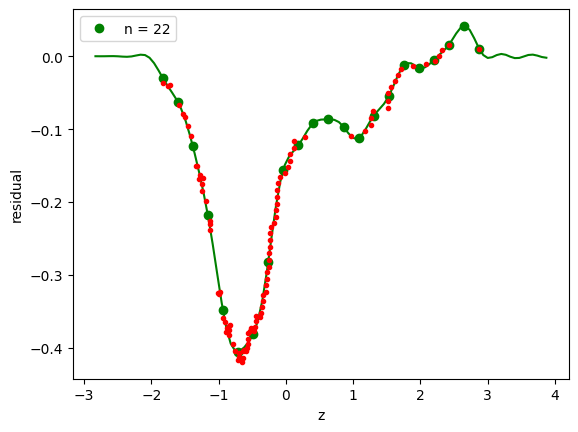

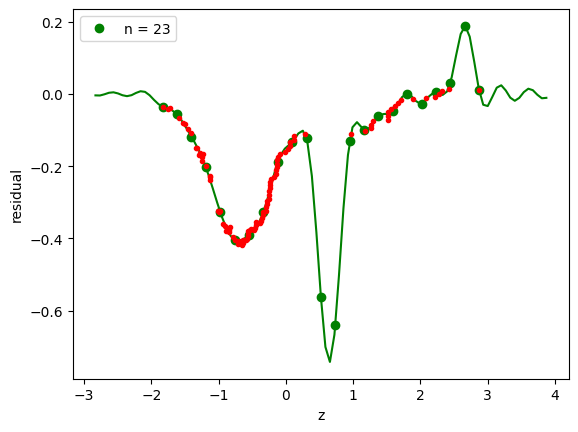

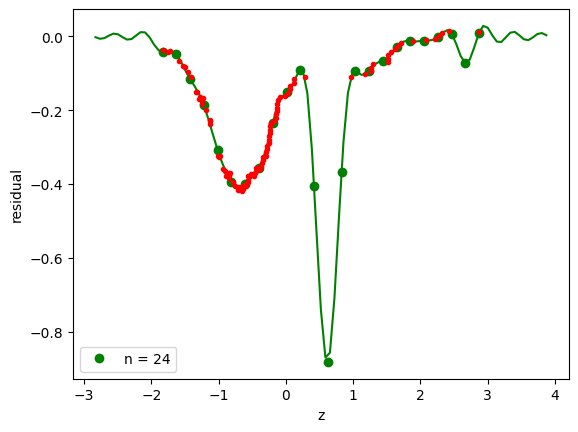

In [231]:
for (n,sincPoint,_,_) in fitTab:
	plot.plot(*UnZip(sincPoint), 'o', markersize=6, c='green', label=f'n = {n}')
		
	zGrid = Grid1(zMin - 1, zMax + 1, nPlot)
	interpV = Interp(sincPoint, zGrid)
	plot.plot(zGrid,interpV, c='green')	
	
	plot.plot(*UnZip(sampPoint), '.', c='red')
	
	plot.xlabel('z')
	plot.ylabel('residual')
	plot.legend()
	
	plot.show()

## Do L-Infinity

In [232]:
def LInf(sincPoint, sampPoint):
	sampZ,sampV = UnZip(sampPoint)
	
	interpV = Interp(sincPoint, sampZ)
	diff = tuple(sV - eV for (eV,sV) in zip(sampV, interpV))
	result = max(abs(d) for d in diff)
	
	return result

In [233]:
fitTab[0]

(3,
 ((-1.8322009125466414, -0.177880204746658),
  (0.5214061668069088, -0.23237437474162043),
  (2.875013246160459, 0.11715377134455088)),
 0.7735469018062103,
 3.152969980382798)

Text(0, 0.5, 'lInv')

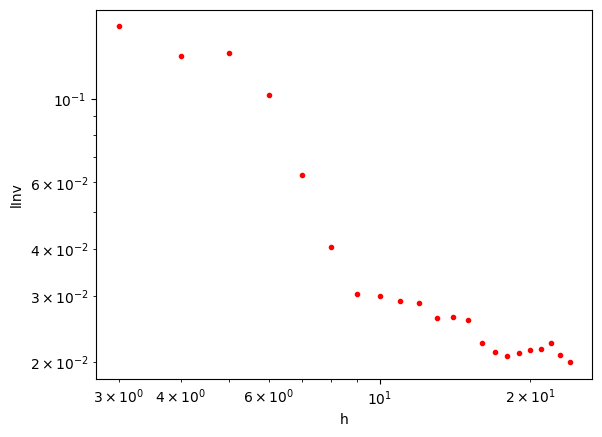

In [234]:
lInf = tuple(LInf(sincPoint, sampPoint) for (_,sincPoint,_,_) in fitTab)
plot.loglog(nL, lInf, '.', c='red')

plot.xlabel('h')
plot.ylabel('lInv')